In [1]:
import time

from FNFTpy import nsev
from FNFTpy import nsev_inverse, nsev_inverse_xi_wrapper
import numpy as np
import pandas as pd
import random
import timeit
from tqdm import tqdm
from scipy.fft import fft, ifft, fftfreq, fftshift, ifftshift

import matplotlib.pyplot as plt
import matplotlib

import multiprocessing as mp

from importlib import reload

import ssfm
reload(ssfm)

import signal_generation as sg
reload(sg)

import nft_analyse as nft
reload(nft)

from os.path import exists


In [2]:
def create_signal_burst(num_symbols, p_ave_dbm, seed=0):

    # Create real signal
    # signal parameters
    mod_type = "16qam"
    n_car = 1
    t_symb = 1.

    # num_symbols = 2 ** 6
    np_symb = 16
    n_lateral_symbols = 2 ** 6
    n_lateral = n_lateral_symbols * np_symb
    # n_lateral = 0
    p_ave = sg.dbm_to_nd(p_ave_dbm, t_symb=14.8)
    roll_off = 0.1
    # calc_type = 1
    xi_upsampling = 1

    dt = t_symb / np_symb

    # generate bit sequence
    n_bits = n_car * sg.get_n_bits(mod_type) * num_symbols
    random.seed(seed)
    bits = random.getrandbits(n_bits)
    data = "{0:b}".format(int(bits))
    if len(data) < n_bits:
        data = ''.join('0' for add_bit in range(n_bits - len(data))) + data

    # create signal and set power
    signal = sg.get_wdm_signal(data, t_symb, np_symb, sg.rcos, [t_symb, roll_off],
                               n_carriers=n_car, mod_type=mod_type, n_lateral=n_lateral)
    q = sg.set_average_power(signal, dt, p_ave, len(signal) // 2 - n_lateral)

    n_power = 1
    n_add = (sg.round_power_of_2(n_power, len(q)) - len(q)) // 2
    while n_add * dt < 800:
    # if n_add * dt < 400:
        # 400 for 100nd
        n_power += 1
        n_add = (sg.round_power_of_2(n_power, len(q)) - len(q)) // 2
    q = sg.add_lateral(q, n_add)
    print(len(q))

    # so finally we add to signal n_lateral + n_add points for each side

    # create time and spectrum
    n_t = len(q)
    # t = np.array([(i - (n_t - 1) / 2) * dt for i in range(n_t)])
    t = np.array([(i - n_t / 2) * dt for i in range(n_t)])
    t_span = t[-1] - t[0]

    points_orig = np.array(sg.get_constellation_point(data, type=mod_type))
    points_restored = np.array(sg.get_points_wdm(q, t_symb, np_symb, None, None, n_carriers=n_car, mod_type=mod_type, n_lateral=n_lateral + n_add))
    constellation_scale = sg.get_scale_coef(points_restored, mod_type)
    points_restored = sg.get_scale_coef(points_restored, mod_type) * points_restored

    return {'q': q,
            't': t,
            'n_lateral': n_lateral,
            'n_add': n_add,
            'constellation_scale': constellation_scale,
            'points_orig': points_orig
            }

def propagate(q_init, t_span, n_fiber_span=25):

    z_80km_nd = sg.z_km_to_nd(80, t_symb=14.8)
    # total 2000 km = 25 * 80 km

    beta2 = -1.0
    gamma = 1.0

    q_propagated = []
    q_prop = q_init

    n_z_prop = 2 ** 8
    for k_span in range(n_fiber_span):
        q_prop = ssfm.fiber_propogate(q_prop, t_span, z_80km_nd, n_z_prop, gamma=gamma, beta2=beta2)
        q_propagated.append(q_prop)

    return q_propagated

def make_dbp(q_propagated, t):

    n_fiber_span = len(q_propagated)
    z_80km_nd = sg.z_km_to_nd(80, t_symb=14.8)

    q_restored = []

    for k_span in range(n_fiber_span):

        result_dbp_nft = nft.make_dbp_nft(q_propagated[k_span], t, (k_span + 1) * z_80km_nd, xi_upsampling=4)
        q_total = result_dbp_nft['q_total']
        q_restored.append(q_total)

    return q_restored

def get_points(q_restored, scale, n_add):

    t_symb = 1.0
    np_symb = 16
    mod_type = "16qam"
    n_car = 1

    points = []
    n_fiber_span = len(q_restored)
    for k in range(n_fiber_span):
        points_tib = scale * np.array(sg.get_points_wdm(q_restored[k], t_symb, np_symb, None, None, n_carriers=n_car, mod_type=mod_type, n_lateral=n_add))
        points.append(points_tib)

    return points

def get_ber(points_orig, points):

    mod_type = "16qam"
    n_fiber_span = len(points)
    ber = []
    for k in range(n_fiber_span):
        points_tib_found = sg.get_nearest_constellation_points(points[k], mod_type)
        ber.append(sg.get_ber_by_points(points_orig, points_tib_found, mod_type))

    return ber

def get_nmse(q_init, q_restored, n_add):
    # to find exact metric we have to delete n_lateral + n_add points first
    # [n_add + n_lat : len(q) - (n_lat + n_add)]
    # mse = (np.square(A - B)).mean(axis=ax)

    n_t = len(q_init)
    n_fiber_span = len(q_restored)
    nmse = []
    for k in range(n_fiber_span):
        nmse.append((np.square(np.absolute(q_init[n_add : n_t - n_add] - q_restored[k][n_add : n_t - n_add]))).mean(axis=0)
                    / (np.square(np.absolute(q_init[n_add : n_t - n_add]))).mean(axis=0))

    return nmse

def run(num_symbols, p_ave_dbm, k_run, results):

    time_start = time.time()
    init_dict = create_signal_burst(num_symbols, p_ave_dbm, seed=k_run)
    q_init = init_dict['q']
    t = init_dict['t']
    t_span = t[-1] - t[0]
    n_add = init_dict['n_lateral'] + init_dict['n_add']

    points_orig = init_dict['points_orig']
    scale = init_dict['constellation_scale']

    q_propagated = propagate(q_init, t_span, n_fiber_span=25)
    q_restored = make_dbp(q_propagated, t)
    points = get_points(q_restored, scale, n_add)

    ber = get_ber(points_orig, points)
    nmse = get_nmse(q_init, q_restored, n_add)

    current_result = {'run': k_run,
                      'n_fiber_span': 25,
                      'num_symbols': num_symbols,
                      'p_ave_dbm': p_ave_dbm,
                      'q_init': q_init,
                      't': t,
                      'points_orig': points_orig,
                      'scale': scale,
                      'q_propagated': q_propagated,
                      'q_restored': q_restored,
                      'points': points,
                      'ber': ber,
                      'nmse': nmse
                      }

    results.append(current_result)

    # print(current_result)
    # save to file
    df_run = pd.DataFrame()
    df_run = df_run.append(current_result, ignore_index=True)
    df_run.to_pickle("nft_dbp_nsym" + str(num_symbols) + "_p" + str(p_ave_dbm) + "_r" + str(k_run) + ".pkl")
    # df_total = df_total.append(df_run)

    # return df_run

    time_end = time.time()
    print('time, s:', time_end - time_start)

    return current_result

def run_collection(num_symbols_list, p_ave_dbm_list, k_run_list):

    # read from file
    df_all = pd.DataFrame()

    for k_run in k_run_list:
        for num_symbols in num_symbols_list:
            for p_ave_dbm in p_ave_dbm_list:
                file_name = "nft_dbp_nsym" + str(num_symbols) + "_p" + str(p_ave_dbm) + "_r" + str(k_run) + ".pkl"
                if exists(file_name):
                    df_load = pd.read_pickle(file_name)
                    df_all = df_all.append(df_load, ignore_index=True)

    # return df_run

    return df_all

def collect_result(result):
    # print(result)
    # df.append(result, ignore_index=True)
    print('done')

In [3]:
# num_symbols_list = [2**7, 2**8, 2**9]
# p_ave_dbm_list = [-10, -4, -2, -1, 0, 1, 2, 5]
num_symbols_list = [2**7]
p_ave_dbm_list = [-1, 0, 1, 2]
n_run = 10

# df = pd.DataFrame()
# df2 = pd.DataFrame()

results = []

# pool = mp.Pool(mp.cpu_count() - 2)

for k_run in range(1, n_run + 1):
    for num_symbols in num_symbols_list:
        for p_ave_dbm in p_ave_dbm_list:

            df_current = run(num_symbols, p_ave_dbm, k_run, results)
            # pool.apply_async(run, args=(num_symbols, p_ave_dbm, k_run, results), callback=collect_result)
            # print(df_current)
            # df = df.append(df_current, ignore_index=True)

# pool.close()
# pool.join()

# df.to_pickle("nft_dbp_total.pkl")

32768
time, s: 13474.742089986801
32768
time, s: 13724.666198730469
32768
time, s: 13706.914285421371
32768
time, s: 13736.945748567581
32768
time, s: 13744.441366434097
32768
time, s: 13682.843286275864
32768
time, s: 13872.739312887192
32768
time, s: 13788.219517230988
32768
time, s: 13905.643374919891
32768
time, s: 13902.77128815651
32768
time, s: 13955.608537435532
32768
time, s: 14317.944320678711
32768
time, s: 14261.938756465912
32768
time, s: 14338.440175056458
32768
time, s: 14310.595184087753
32768
time, s: 14278.359061717987
32768
time, s: 14366.79009103775
32768
time, s: 14288.702946901321
32768
time, s: 14337.399673461914
32768
time, s: 14433.07300209999
32768
time, s: 14412.910945653915
32768
time, s: 14444.144975662231
32768
time, s: 14298.331928491592
32768
time, s: 14310.438948869705
32768
time, s: 16305.251089811325
32768
time, s: 14410.7010409832
32768
time, s: 14383.538227081299
32768
time, s: 14431.938780784607
32768
time, s: 14460.92216539383
32768
time, s: 15254

KeyboardInterrupt: 

In [12]:
num_symbols_list = [2**7, 2**8, 2**9]
p_ave_dbm_list = [-10, -4, -2, -1, 0, 1, 2, 5]

df = run_collection(num_symbols_list, p_ave_dbm_list, [0])

In [13]:
print(df)

                                                  ber  n_fiber_span  \
0   [(0.0, 0), (0.0, 0), (0.0, 0), (0.0, 0), (0.0,...          25.0   
1   [(0.0, 0), (0.0, 0), (0.0, 0), (0.0, 0), (0.0,...          25.0   
2   [(0.017578125, 9), (0.017578125, 9), (0.017578...          25.0   
3   [(0.013671875, 7), (0.013671875, 7), (0.013671...          25.0   
4   [(0.001953125, 1), (0.001953125, 1), (0.001953...          25.0   
5   [(0.0, 0), (0.0, 0), (0.0, 0), (0.0, 0), (0.0,...          25.0   
6   [(0.021484375, 11), (0.01953125, 10), (0.01953...          25.0   
7   [(0.501953125, 257), (0.501953125, 257), (0.50...          25.0   
8   [(0.0, 0), (0.0, 0), (0.0, 0), (0.0, 0), (0.0,...          25.0   
9   [(0.0029296875, 3), (0.0029296875, 3), (0.0029...          25.0   
10  [(0.0126953125, 13), (0.0126953125, 13), (0.01...          25.0   
11  [(0.03515625, 36), (0.03515625, 36), (0.036132...          25.0   
12  [(0.001953125, 2), (0.001953125, 2), (0.001953...          25.0   
13  [(

In [82]:
distance = [80 * i for i in range(25)]

ns_plot = 256
# print((df[(df.num_symbols == ns_plot)]))

dbm_values = (df[(df.num_symbols == ns_plot)])['p_ave_dbm'].to_numpy()
ber_values = (df[(df.num_symbols == ns_plot)])['ber'].to_numpy()
nmse_values = (df[(df.num_symbols == ns_plot)])['nmse'].to_numpy()
print(dbm_values[7])
print(ber_values[7])
print(nmse_values[7])

# k = 7
# print([ber_values[k][l][0] for l in range(len(ber_values[k]))])

5.0
[(0.4921875, 504), (0.4921875, 504), (0.4921875, 504), (0.4921875, 504), (0.4921875, 504), (0.4921875, 504), (0.4921875, 504), (0.4921875, 504), (0.4921875, 504), (0.4921875, 504), (0.4921875, 504), (0.4921875, 504), (0.4921875, 504), (0.4921875, 504), (0.4921875, 504), (0.4921875, 504), (0.4921875, 504), (0.4921875, 504), (0.4921875, 504), (0.4921875, 504), (0.4921875, 504), (0.4921875, 504), (0.4921875, 504), (0.4921875, 504), (0.4921875, 504)]
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


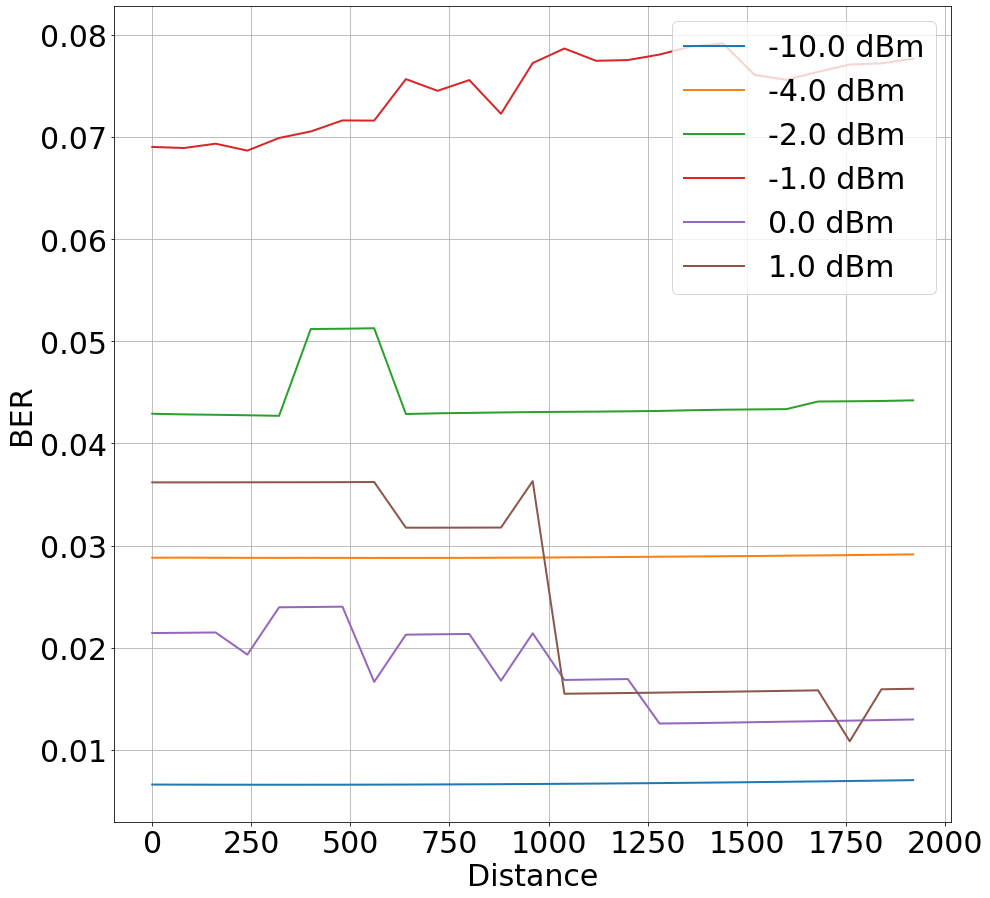

In [92]:
matplotlib.rcParams.update({'font.size': 30})

fig, axs = plt.subplots(1, 1, figsize=(15,15))
for k in range(0,6):
    ber_plot = [ber_values[k][l][0] for l in range(len(ber_values[k]))]
    nmse_plot = nmse_values[k]
    axs.plot(distance, nmse_plot,
             linewidth=2,
             label=str(dbm_values[k]) + ' dBm')
# axs[0].plot(t, np.absolute(q_fnft), 'green', linewidth=4)
# axs[0].plot(t, np.absolute(q_total), 'purple', linewidth=3)
# axs[0].set_xlim(-30., 30.)
# ax.set_xlim(-t_span / 2., t_span / 2.)
# axs[0].set_ylim(0, 20)
# axs.set_yscale('log')
axs.set_xlabel('Distance')
axs.set_ylabel('BER')
axs.legend()
axs.grid(True)


In [ ]:
print(results)

In [14]:
df = df.append({"q": 1, "r": 2}, ignore_index=True)

In [15]:
print(df)

     q    r
0  1.0  2.0
1  1.0  2.0


[0.+0.j 0.+0.j 0.+0.j ... 0.+0.j 0.+0.j 0.+0.j]


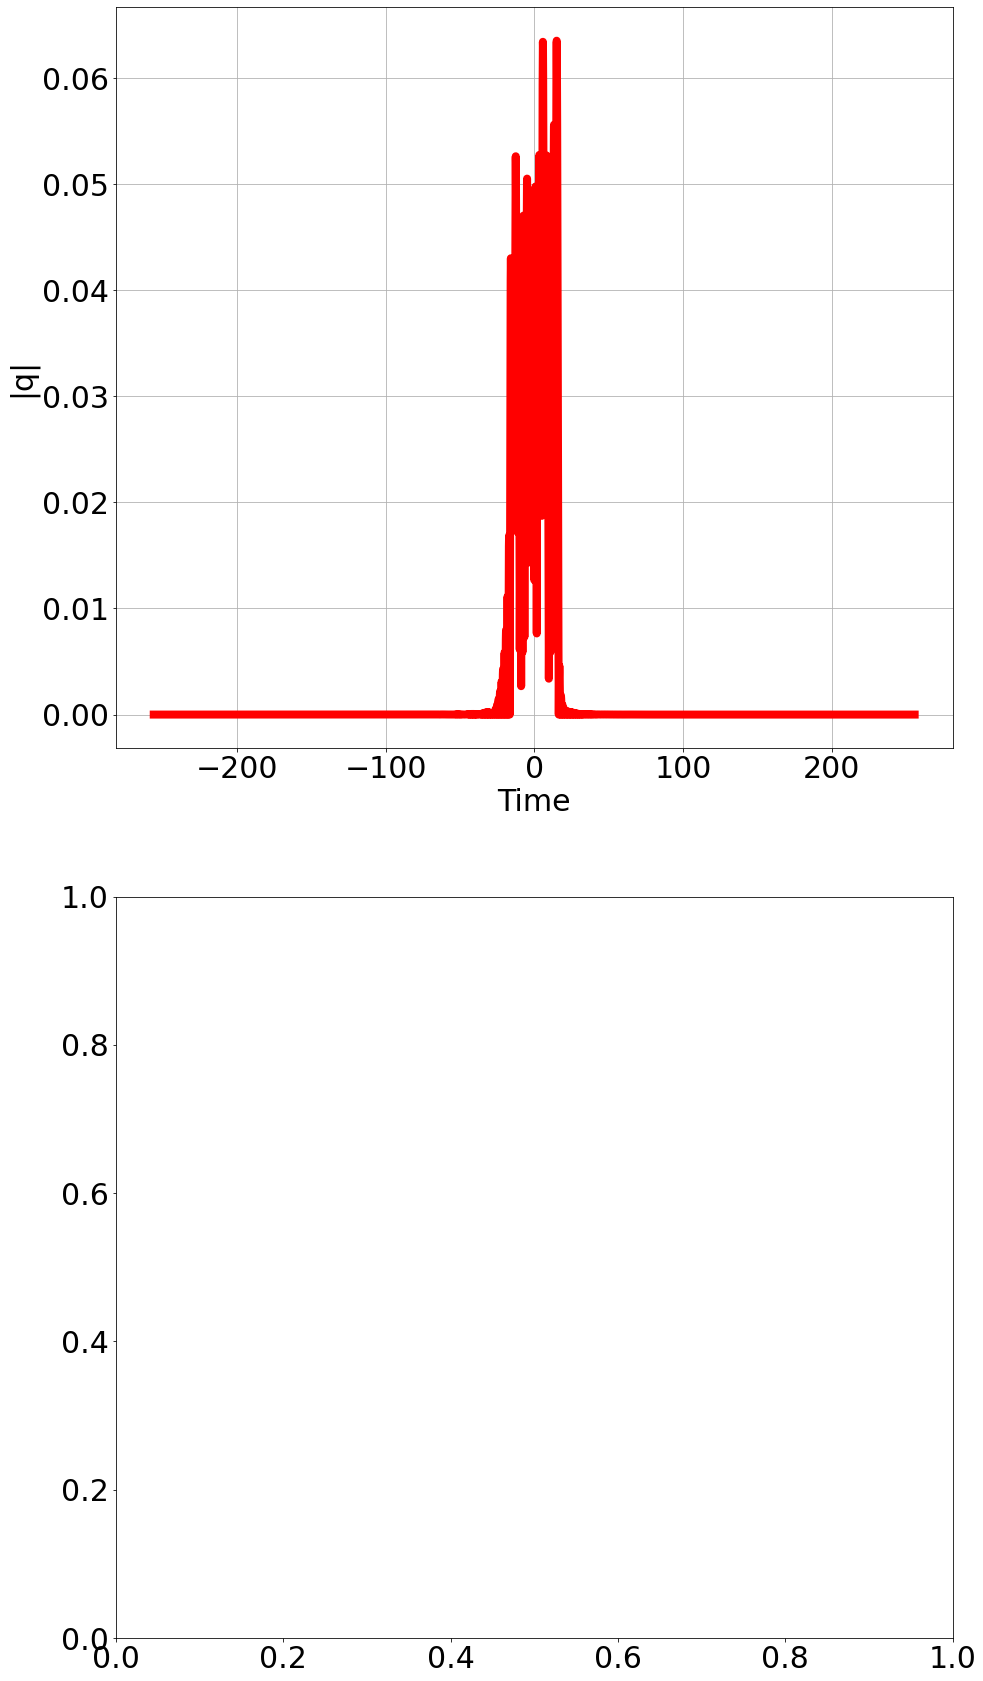

In [11]:
df_load = pd.read_pickle("nft_dbp_nsym32_p-10_r0.pkl")

# df = df.append(df_current, ignore_index=True)
print(df_load['q_init'][0])
q_test = df_load['q_init'][0]


matplotlib.rcParams.update({'font.size': 30})

fig, axs = plt.subplots(2, 1, figsize=(15,30))
axs[0].plot(t, np.absolute(q_test), 'red', linewidth=8)
# axs[0].plot(t, np.absolute(q_fnft), 'green', linewidth=4)
# axs[0].plot(t, np.absolute(q_total), 'purple', linewidth=3)
# axs[0].set_xlim(-30., 30.)
# ax.set_xlim(-t_span / 2., t_span / 2.)
# axs[0].set_ylim(0, 20)
axs[0].set_xlabel('Time')
axs[0].set_ylabel('|q|')
axs[0].grid(True)

In [8]:
# Test functions

init_dict = create_signal_burst(2 ** 6, 4)
q_init = init_dict['q']
n_add = init_dict['n_lateral'] + init_dict['n_add']
print('Length of q:', len(q_init))
t = init_dict['t']
t_span = t[-1] - t[0]

q_propagated = propagate(q_init, t_span, n_fiber_span=2)
q_restored = make_dbp(q_propagated, t)

8192
Length of q: 8192


In [23]:
points_orig = init_dict['points_orig']
n_add = init_dict['n_lateral'] + init_dict['n_add']
scale = init_dict['constellation_scale']
points = get_points(q_restored, scale, n_add)
print(get_ber(points_orig, points))

print(get_nmse(q_init, q_restored, n_add))

[(0.0, 0), (0.0, 0)]
[0.006706687843394357, 0.006706819791946733]


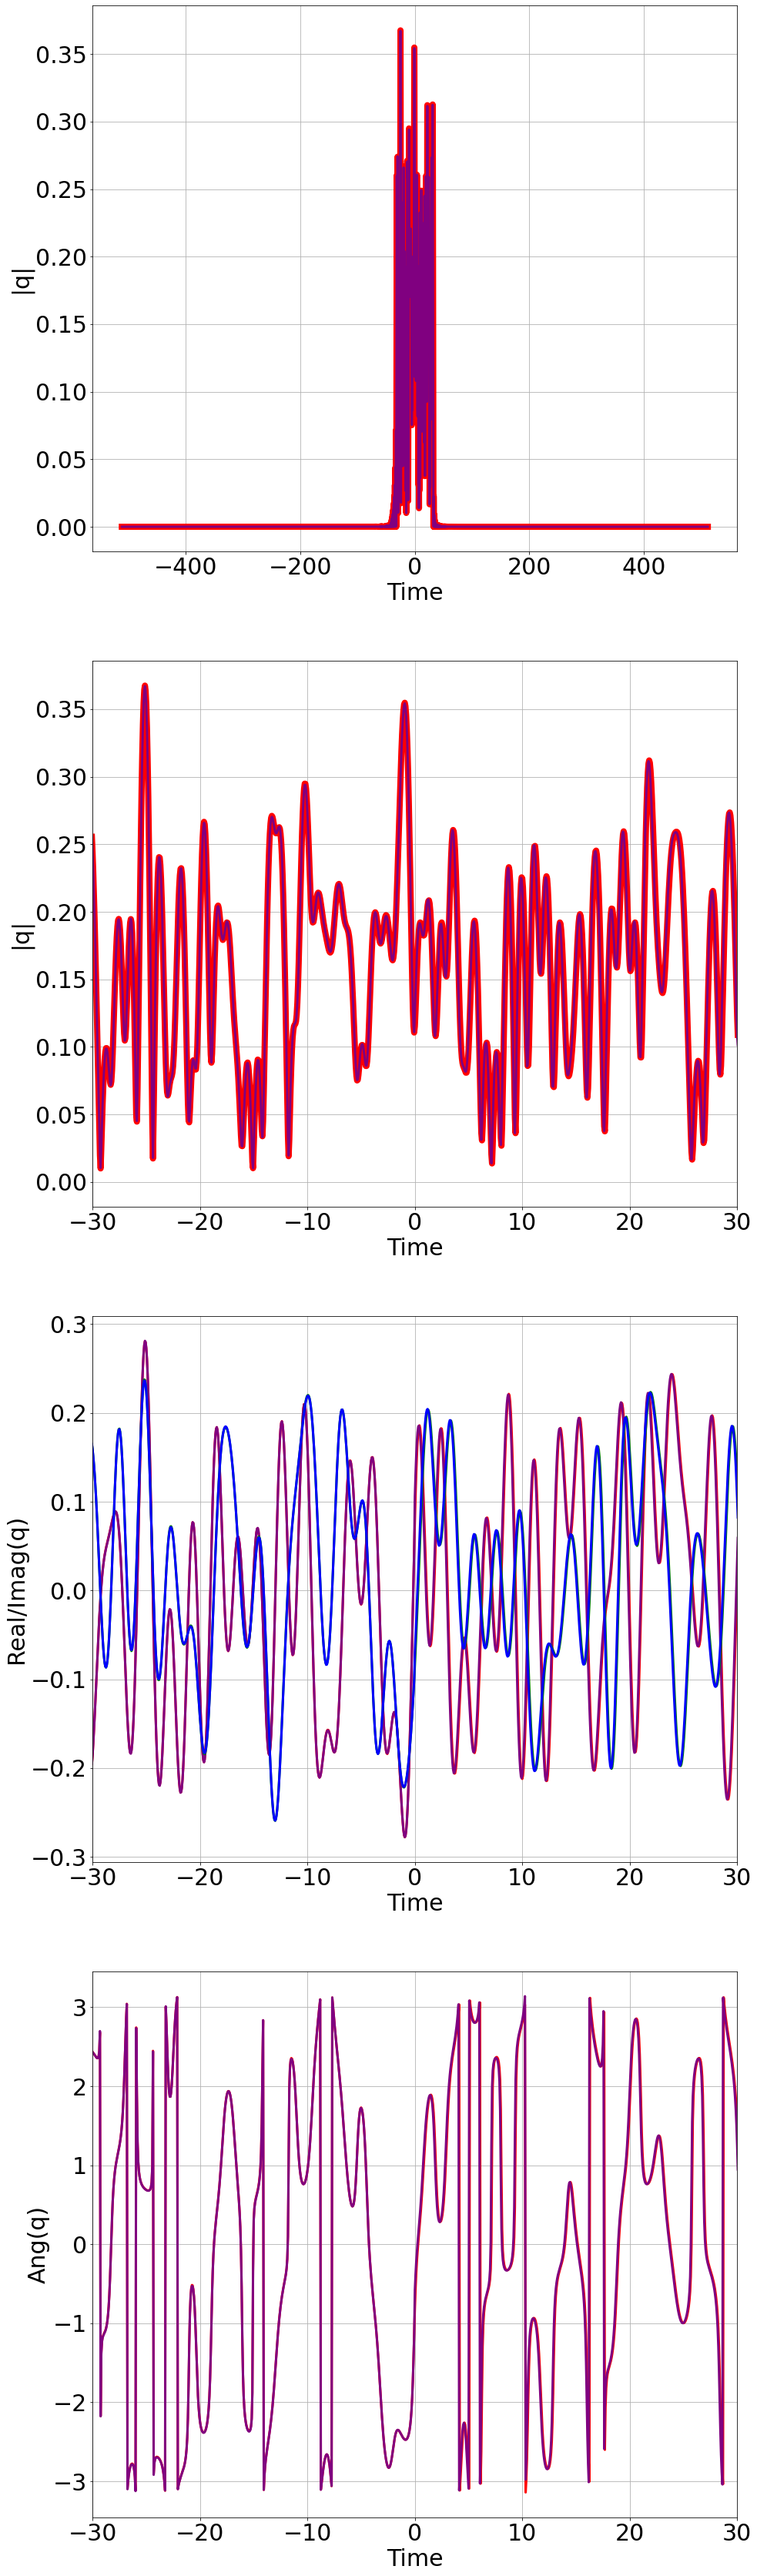

In [24]:
q_total = q_restored[1]

matplotlib.rcParams.update({'font.size': 30})

fig, axs = plt.subplots(4, 1, figsize=(15,60))
axs[0].plot(t, np.absolute(q_init), 'red', linewidth=8)
# axs[0].plot(t, np.absolute(q_fnft), 'green', linewidth=4)
axs[0].plot(t, np.absolute(q_total), 'purple', linewidth=3)
# axs[0].set_xlim(-30., 30.)
# ax.set_xlim(-t_span / 2., t_span / 2.)
# axs[0].set_ylim(0, 20)
axs[0].set_xlabel('Time')
axs[0].set_ylabel('|q|')
axs[0].grid(True)

axs[1].plot(t, np.absolute(q_init), 'red', linewidth=8)
# axs[1].plot(t * coef_t_draw, np.absolute(q_fnft), 'green', linewidth=4)
axs[1].plot(t, np.absolute(q_total), 'purple', linewidth=3)
# axs[1].plot(t * coef_t_draw, np.absolute(q_total_inv[::-1]), 'xkcd:cyan', linewidth=3)
axs[1].set_xlim(-30, 30)
# axs[1].set_ylim(0, 20)
axs[1].set_xlabel('Time')
axs[1].set_ylabel('|q|')
axs[1].grid(True)

axs[2].plot(t, np.real(q_init), 'red', linewidth=3)
axs[2].plot(t, np.real(q_total), 'purple', linewidth=3)
axs[2].plot(t, np.imag(q_init), 'green', linewidth=3)
axs[2].plot(t, np.imag(q_total), 'blue', linewidth=3)
axs[2].set_xlim(-30, 30)
axs[2].set_xlabel('Time')
axs[2].set_ylabel('Real/Imag(q)')
axs[2].grid(True)

axs[3].plot(t, np.angle(q_init), 'red', linewidth=3)
axs[3].plot(t, np.angle(q_total), 'purple', linewidth=3)
axs[3].set_xlim(-30, 30)
axs[3].set_xlabel('Time')
axs[3].set_ylabel('Ang(q)')
axs[3].grid(True)
